In [303]:
import requests
import time
from bs4 import BeautifulSoup
import json
from tqdm import tqdm
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [304]:
page = 1000
url = "https://www.cupoy.com/MixNewsMongoAction.do?op=getTopMixNewsByBucketGroup&groupid=business_tw&startNewsID=1&len="+str(page)  #財經新聞
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼
j = json.loads(resp.text)
items = j['items']
print(len(items))

1000


In [305]:
j = json.loads(resp.text)
items = j['items']
titles = []
urls = []
fb_shares_arr = [] 
fb_likes_arr = []
gplus_likes_arr = []
pin_counts_arr = []
linkedin_shares_arr = []
reddit_shares_arr = []
nation_arr = []
for i in tqdm(range(len(items))):
    if items[i]['metrics'].__contains__('socialScorer'):
        titles.append(items[i]['title']) 
    #     urls.append(items[i]['linkurl'])
        nation_arr.append(items[i]['nationID'])
        fb_shares_arr.append(items[i]['metrics']['socialScorer']['fb_shares'])
        fb_likes_arr.append(items[i]['metrics']['socialScorer']['fb_likes'])
        gplus_likes_arr.append(items[i]['metrics']['socialScorer']['gplus_likes'])
        pin_counts_arr.append(items[i]['metrics']['socialScorer']['pin_counts'])
        linkedin_shares_arr.append(items[i]['metrics']['socialScorer']['linkedin_shares'])
        reddit_shares_arr.append(items[i]['metrics']['socialScorer']['reddit_shares'])

print(len(nation_arr))

100%|██████████| 1000/1000 [00:00<00:00, 86754.17it/s]

999


### Get Publisher from title

In [306]:
publishers = []
for i in tqdm(range(len(titles))):
    x = re.split("(\||\-|\｜)", titles[i])
    length = len(x)
    publish = x[length-1].strip()
    if length == 1: 
        publish = ""
    publishers.append(publish)

100%|██████████| 999/999 [00:00<00:00, 71624.58it/s]


### Remove Publisher from title

In [307]:
non_publisher_titles = []
for i in tqdm(range(len(titles))):
    x = re.split("(\||\-|\｜)", titles[i])
    length = len(x)
#   取0到x-1的字再組起來
    title = ""
    if length == 1:
        title = x[0]
    else:
        j = 0
        #   -2 => 移除 ['｜', '-', '|'] 以及出版者
        for j in range(length-2):
            title = title + x[j]
    non_publisher_titles.append(title)
print(len(non_publisher_titles))

100%|██████████| 999/999 [00:00<00:00, 103620.69it/s]

999


In [308]:
news_dict = {
    "titles": non_publisher_titles,
#     "urls": urls,
    "publishers":publishers,
    "fb_shares":fb_shares_arr,
    "fb_likes": fb_likes_arr,
    "gplus_likes":gplus_likes_arr,
    "pin_counts":pin_counts_arr,
    "linkedin_shares":linkedin_shares_arr,
    "reddit_shares":reddit_shares_arr
}
df = pd.DataFrame(news_dict)

#  Remove Pusblisher is empty
df = df[df['publishers']!=""]
df.sort_values(by=['fb_shares'], inplace=True, ascending=False)
df

,titles,publishers,fb_shares,fb_likes,gplus_likes,pin_counts,linkedin_shares,reddit_shares
535,【不敢回臺灣的護理師】臺灣護士薪水只有美國診所的一半，工作量卻是他們的十倍,BuzzOrange,41962,105,0,0,0,0
612,【每天都過著超載人生？】臉書前行銷總監、馬克的姊姊：世上沒完美平衡，每天「選 3」就好,VidaOrange,16526,39,0,0,0,0
17,一名社工揭露的街友故事：他們曾經也是老師、醫生、房仲，直到被社會放逐,BuzzOrange,16171,101,0,0,0,0
512,瑞典全國一個月不上班國家也沒倒！而國家並不會因為人民像工蟻不斷工作更有競爭力,BuzzOrange,12069,47,0,0,0,0
517,這個「通病」讓臺灣產業死去──本土遊戲 90 年代曾是亞洲第二，為何最後走向沒落？,BuzzOrange,8342,101,0,0,0,0
...,...,...,...,...,...,...,...,...
336,在現實世界拓展機器學習應用的三種方法,數位時代,0,0,0,0,0,0
337,華航宣佈主管減薪10％！因武漢肺炎疫情影響，鼓勵員工主動休假、共體時艱,數位時代,0,0,0,0,0,0
338,抗武漢肺炎，在家工作也不怕！6款超強大遠距辦公工具懶人包，快給老闆看,數位時代,0,0,0,0,0,0
341,鑽石公主號兩名乘客死亡！NHK快訊：政府官員承認，兩名80多歲確診本國乘客不治,風傳媒,0,0,0,0,0,0


### 計算TFIDF詞頻
1. 將所有需計算的組成字串
2. jieba進行分詞
3. 使用jieba進行tfidf計算

In [309]:
from tqdm import tqdm
import jieba
import jieba.analyse
jieba.set_dictionary('dict.txt.big')

def caculate_TFIDF(datalist):
    # 將所有需計算的組成字串
    word_string = ""
    for data in datalist:
        word_string = word_string + "，" + data
        
    #  jieba進行分詞
    cut_words = jieba.cut(word_string, cut_all=False)
    words = list(cut_words)
    
   #使用jieba進行tfidf計算
    #  tfidf = jieba.analyse.extract_tags(word_string, 10)
    tfidf = jieba.analyse.extract_tags(word_string, topK=40, withWeight=False, allowPOS=())
    return tfidf



tfidf = caculate_TFIDF(df['titles'])
tfidf

Building prefix dict from /Users/fan/Documents/Github/pycrawler-project/dict.txt.big ...
Loading model from cache /var/folders/32/4nbdc94x4w71n8cppyr49lz00000gn/T/jieba.u90c238c6edb188e7c4dcfaeaef1126cb.cache
Loading model cost 7.774 seconds.
Prefix dict has been built successfully.


['投資',
 '趨勢',
 '未來',
 '疫情',
 'Anue',
 '財訊',
 '武漢',
 '中國',
 '臺灣',
 '肺炎',
 '什麼',
 '員工',
 '觀點',
 '掌握',
 '工作',
 '職場',
 '企業',
 '...',
 '理財',
 '為何',
 '10',
 '商業',
 '美國',
 '衝擊',
 '財經',
 '影響',
 '怎麼',
 '經濟',
 '產業',
 '時間',
 '週刊',
 '成為',
 '關鍵',
 '老闆',
 '2020',
 '旅遊',
 '新冠',
 '如何',
 '不會',
 '問題']

In [312]:
#移除Stop_words
def remove_stop_words(file_name,seg_list):
    with open(file_name,'r') as f:
        stop_words = f.readlines()
    stop_words = [stop_word.strip() for stop_word in stop_words]
    new_list = []
    for seg in seg_list:
        if seg not in stop_words and seg.isspace()==False:
            new_list.append(seg) #若在for loop裡用remove的話則會改變總長度
    return new_list


word_string = ''
for data in df['titles']:
    word_string = word_string + "，" + data

#  jieba進行分詞
cut_words = jieba.cut(word_string, cut_all=False)
words = list(cut_words)

# 移除空白字元
for word in words:
    if(word.isspace()):
        words.remove(word)

file_name = './stop_words_chinese.txt'
seg_list = remove_stop_words(file_name,words)
print('remove_stop_words: ',seg_list[1:200]) # 列出200個

remove_stop_words:  ['回', '臺灣', '護理', '師', '臺灣', '護士', '薪水', '美國', '診所', '一半', '工作量', '卻是', '十倍', '每天', '過著', '超載', '人生', '臉書前', '行銷', '總監', '馬克', '姊姊', '世上', '完美', '平衡', '每天', '選', '好', '一名', '社工', '揭露', '街友', '故事', '曾經', '老師', '醫生', '房仲', '直到', '社會', '放逐', '瑞典', '全國', '一個月', '上班', '國家', '倒', '國家', '工蟻', '不斷', '工作', '競爭力', '通病', '臺灣', '產業', '死去', '本土', '遊戲', '90', '年代', '曾', '亞洲', '第二', '最後', '走向', '沒落', '年輕', '時多', '努力', '逼', '年輕人', '走向', '死亡', '錯誤', '神話', '臺灣', '一年', '青年', '自殺', '日本', '青年', '自殺', '率', '世界', '第一', '今天', '多賺', '幾小時', '盤點', '時間', '損益表', '奪回', '最', '寶貴', '時間', '心理學家', '職場', '觀察', '公司', '裡的', '種人', '最累', '這種', '點子', '美國', '商務', '顧問', '創意', '源源不絕', '人', '特質', '目前', '工作', '感到', '迷惘', '時', '應先問', '三個', '問題', '學', '經歷', '漂亮', '一定', '好', '推動', '公司', '成長', '人才', '擁有', '特質', '30', '歲', '迷惘', '人生哲學', '電影片', '陪', '度過', '灰濛濛', '迷惘', '期', '怎樣才能', '談到', '好', '薪水', '先', '出手', '一直', '討論', '錢', '學習', '運動', '總是', '半途而廢', '美國', '企管', '顧問', '拋棄', '錯誤', '自律', '養成', '卓越', '好', '習慣', '買', '新

In [313]:
# 統計詞頻
import pandas as pd
def count_segment_freq(seg_list):
    seg_df = pd.DataFrame(seg_list,columns=['seg'])
    seg_df['count'] = 1
    sef_freq = seg_df.groupby('seg')['count'].sum().sort_values(ascending=False)
    sef_freq = pd.DataFrame(sef_freq)
    return sef_freq

sef_freq = count_segment_freq(seg_list)
sef_freq.head()

,count
seg,
工作,83
投資,82
疫情,80
肺炎,62
趨勢,61


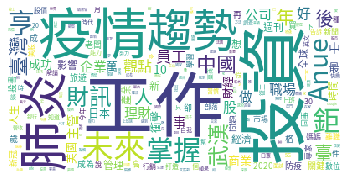

In [314]:
wc = WordCloud(background_color='white', font_path = './NotoSansCJKtc-Regular.otf')
sef_freq_dict = sef_freq.to_dict()
# print(sef_freq_dict)
wc.generate_from_frequencies(sef_freq_dict['count'])
import matplotlib.pyplot as plt
plt.imshow(wc)
plt.axis("off")
plt.show()